In [1]:
!pip install kaggle

In [2]:
!kaggle competitions download -c dogs-vs-cats

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ronnetawat","key":"b4ba7ead4e8f8fe51222412489046910"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:40<00:00, 23.7MB/s]
100% 812M/812M [00:40<00:00, 21.2MB/s]


In [6]:
!unzip -qq dogs-vs-cats.zip

In [7]:
!unzip -qq train.zip

In [8]:
import os, shutil, pathlib

In [9]:
original_dir = pathlib.Path("train") #path to directory where original dataset was uncompressed
new_base_dir = pathlib.Path("cats_vs_dogs_small") # directory to store our smaller dataset

In [10]:
# utility func to copy cat/dog images from start_index to end_index to the subdir
# new_base_dir/{subset_name}/cat(and /dog)
# subset_name options: "train", "validation", "test"
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000) #create training subset w/ first 1000 images of each category
make_subset("validation", start_index=1000, end_index=1500) #create validation subset w/ 500 images of each category
make_subset("test", start_index=1500, end_index=2500) # create test subset w/ 1000 images of each category

### Building the model

- Same structure as the example done before, just adding 2 more `Conv2D` and `MaxPooling2D` layers.
- Size of feature maps will go from 180x180 pixels to 7 x 7.
- Last layer will be a `Dense` layer with 1 unit and `sigmoid` activation for binary classification.
- Also, we'll start the model with a `Rescaling` layer to rescale image inputs from [0,255] range to [0,1] range.

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [13]:
# model summary

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Turning the data into the appropriate data type: floating-point tensors. Steps:

1. Read the picture files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert them into floating-point tensors.
4. Resize them to 180 x 180.
5. Pack them into batches (batch size of 32).

Use `image_dataset_from_directory()` utility function from keras to set up a data pipeline that can automatically turn image files on disk into batches of preprocessed tensors.

In [15]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

# this returns a tf.data.Dataset object configured to read these files, shuffle them, decode them to tensors, resize them to a shared size, and pack them into batches.

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [16]:
# shapes of the data and labele yielded by the Dataset

for data_batch, labels_batch in train_dataset:
    print("data batch shape: ", data_batch.shape)
    print("labels batch shape: ", labels_batch.shape)
    break

data batch shape:  (32, 180, 180, 3)
labels batch shape:  (32,)


### Fitting the model using `Dataset`

- Use `validation_data` argument to monitor validation metrics.
- Use `ModelCheckpoint` callback to save model after each epoch.
    - `save_best_only=True` and `monitor="val_loss"`

In [17]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch.keras",
    save_best_only=True,
    monitor="val_loss")]

In [18]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.5052 - loss: 0.7387 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4933 - loss: 0.6933 - val_accuracy: 0.5010 - val_loss: 0.6915
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.5230 - loss: 0.7034 - val_accuracy: 0.5440 - val_loss: 0.6943
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5660 - loss: 0.6928 - val_accuracy: 0.5970 - val_loss: 0.6628
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.6413 - loss: 0.6531 - val_accuracy: 0.6120 - val_loss: 0.6439
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.6556 - loss: 0.6163 - val_accuracy: 0.6440 - val_loss: 0.6118
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.6845 - loss: 0.5884 - val_accuracy: 0.6630 - val_loss: 0.6084
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7058 - loss: 0.5512 - val_accuracy: 0.6730 -

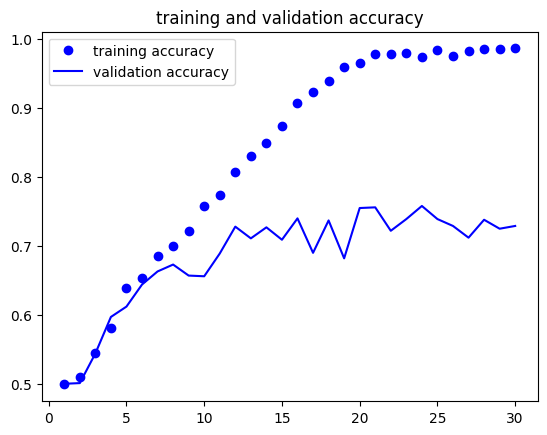

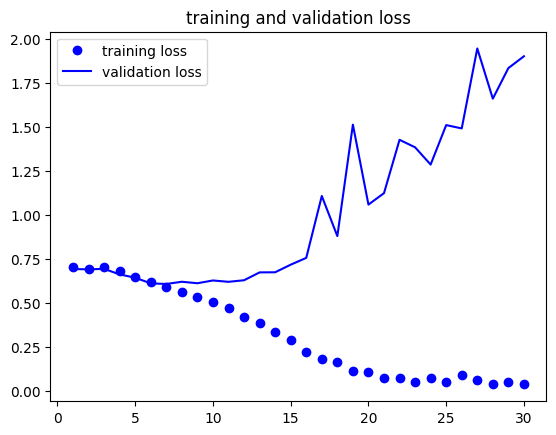

In [19]:
# plotting loss curves and accuracy during training

import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="training accuracy")
plt.plot(epochs, val_accuracy, "b", label="validation accuracy")
plt.title("training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="validation loss")
plt.title("training and validation loss")
plt.legend()
plt.show()

In [21]:
# evaluating the model on the test set

test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.6992 - loss: 0.5857
test accuracy: 0.682


## 8.2.5 Using data augmentation

- Process of generating more training data from existing samples by *augmenting* the samples via a number of random transformations that yield believable-looking images.

- Done in Keras adding a number of *data augmentation layers* at the start.

### Define a data augmentation stage to add to an image model


In [22]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"), #horizontal flipping to a random 50% of the input images
        layers.RandomRotation(0.1), #rotates the image by a random value between [-10%, +10%] fractions of a full circle
        layers.RandomZoom(0.2) #zooms in or out of the image by a random factor in the range [-20%, +20%]
    ]
)

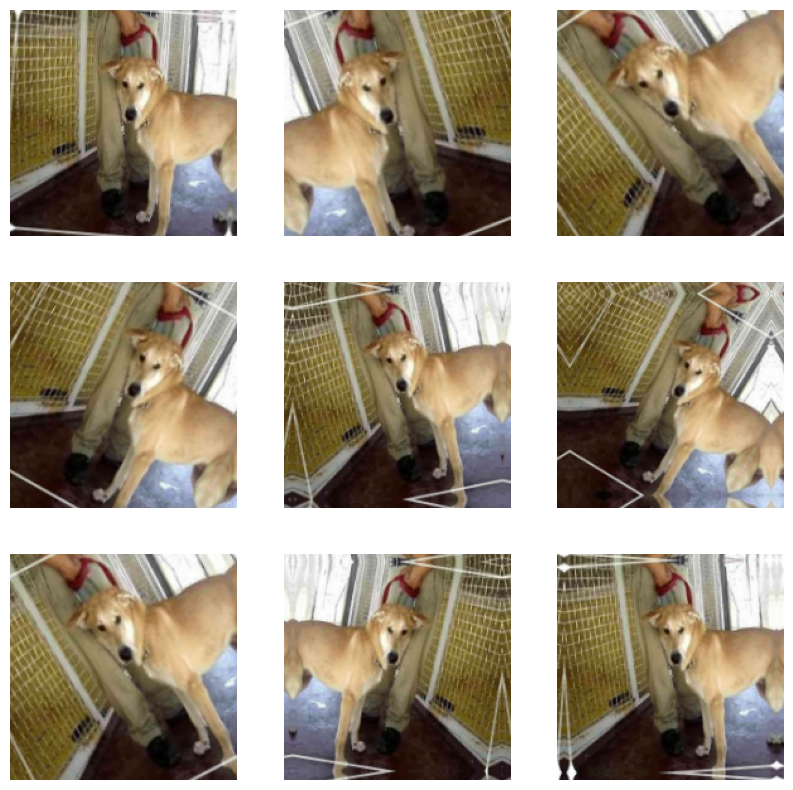

In [23]:
# displaying some randomly augmented training images

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1): #take(N) to only sample N batches from the dataset
  for i in range(9):
    augmented_images = data_augmentation(images) # apply the augmentation stage to the batch of images
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[1].numpy().astype("uint8")) #display 1st image in the output batch
    plt.axis("off")

This doesn't entirely get rid of the overfitting. Sowwe also add a `Dropout` layer right before the densely connected classifier.

### Defining a new CNN that includes image augmentation and dropout

In [24]:
inputs = keras.Input(shape=(180, 180, 3))

x = data_augmentation(inputs) #data augmentation
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.5)(x) #dropout layer

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [25]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [26]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch_augmented.keras",
    save_best_only=True,
    monitor="val_loss")]

In [27]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.5234 - loss: 0.7050 - val_accuracy: 0.5790 - val_loss: 0.6927
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5151 - loss: 0.7055 - val_accuracy: 0.5980 - val_loss: 0.6888
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.5400 - loss: 0.6947 - val_accuracy: 0.5010 - val_loss: 0.6959
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5449 - loss: 0.6880 - val_accuracy: 0.5670 - val_loss: 0.6690
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.6306 - loss: 0.6508 - val_accuracy: 0.6550 - val_loss: 0.6171
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6626 - loss: 0.6174 - val_accuracy: 0.6380 - val_loss: 0.6348
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7019 - loss: 0.6020 - val_accuracy: 0.6720 - val_loss: 0.6026
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.7052 - loss: 0.5686 - val_accuracy: 

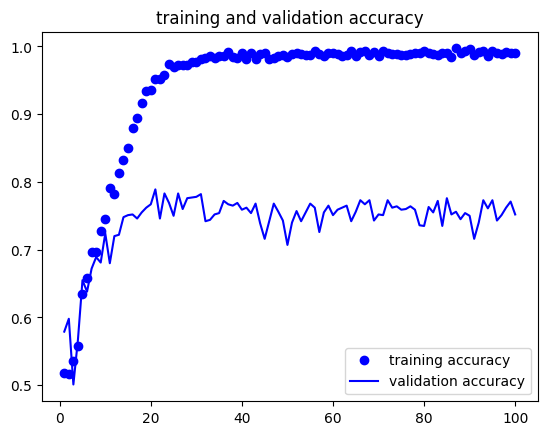

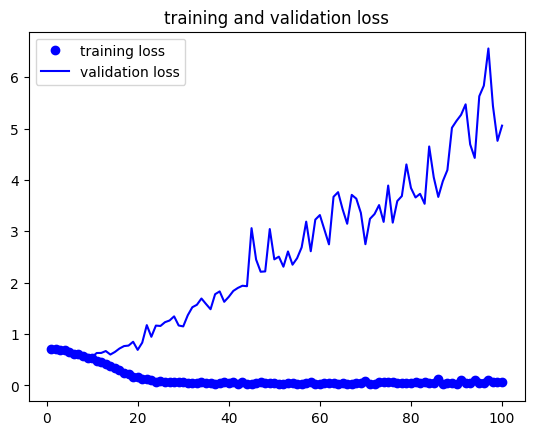

In [28]:
# plotting loss curves and accuracy during training

import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="training accuracy")
plt.plot(epochs, val_accuracy, "b", label="validation accuracy")
plt.title("training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="validation loss")
plt.title("training and validation loss")
plt.legend()
plt.show()

In [29]:
# evaluating the model

test_model = keras.models.load_model("convnet_from_scratch_augmented.keras")

test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"test acc: {test_acc:.3f}")
print(f"test loss: {test_loss:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7386 - loss: 0.5407
test acc: 0.717
test loss: 0.567
